In [1]:
%load_ext autoreload
%autoreload 2

# Orthogonality of all known sRNAs to all known mRNAs, recorded as transcription units, in E. coli

Previously, we looked at how the sRNAs documented in the RNAInter database interact with all of the mRNAs in the RNAInter database, in other words the activity of the sRNAs on the mRNAs known to be regulated by sRNAs in general. Now we will look at how orthogonal the sRNAs are to any mRNA present in E. coli. The transcriptional units from the EcoCyc database represent all known mRNAs and the sRNAs are pulled from both the RNAInter and EcoCyc databases. 

# Imports

In [2]:
import os
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import pandas as pd

from synbio_morpher.srv.io.manage.script_manager import script_preamble
from synbio_morpher.srv.parameter_prediction.IntaRNA.bin.copomus.IntaRNA import IntaRNA
from synbio_morpher.srv.parameter_prediction.simulator import process_raw_stdout
from synbio_morpher.utils.circuit.common.config_setup import retrieve_default_args, load_simulator_kwargs
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.misc.numerical import count_monotonic_group_lengths, find_monotonic_group_idxs
from synbio_morpher.utils.misc.string_handling import string_to_tuple_list
from synbio_morpher.utils.misc.type_handling import get_nth_elements

from subprocess import Popen, PIPE, run
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import jax



In [3]:
fn_tus = os.path.join('..', 'data', 'sRNA', 'EcoCyc', 'EcoCyc_TUs.csv')
fn_merged = os.path.join('..', 'data', 'sRNA', 'merged_EcoCyc_RNAInter_sRNATarBase.csv')
d_tus = pd.read_csv(fn_tus)
d_merged = pd.read_csv(fn_merged)
try:
    d_tus = d_tus.drop(columns=['Unnamed: 0'])
    d_merged = d_merged.drop(columns=['Unnamed: 0'])
except:
    pass


In [4]:
d_tus['Sequence - Length'] = d_tus['Sequence - DNA sequence'].str.len()
d_merged.head()

Name             ID Category Symbol  \
0  acnA    NCBI:946724     mRNA   acnA   
1  acrZ    NCBI:945365     mRNA   acrZ   
2  arcZ   NCBI:2847690     sRNA   arcZ   
3  argR    NCBI:947861     mRNA   argR   
4  arrS  NCBI:11115378     sRNA   arrS   

                                            Sequence  Database  
0  ATTCGGAACGAGGCCTGAAGCAGTGTCGCCGTCCCTCTGCCTTGCA...  RNAInter  
1  ACTTACTACTGTCTTCGGGGGGTCCGAGGTTTCTGGGGGGTCGTAC...  RNAInter  
2  CTCATGTTGACCGCTTGTTTAGCAGCTTCAAGGAAGCTGAAGGGCA...  RNAInter  
3  GACAATGGCGATAGTATGGCGGTTGTTTCTTTCCCATCTCTACTCA...  RNAInter  
4  CTCTCCCTCTCTTTCTCTCTTCTCCGCGGCGATACGATCCGAGATG...  RNAInter

In [5]:
print(len(d_tus))
nn = np.sum(np.arange(1, len(d_tus)+1)) + len(d_tus)
print('Expected number of species: ', nn)
print('Expected number of circuits: ', len(d_merged))
d_tus.head()

3698
Expected number of species:  6843149
Expected number of circuits:  601


Common-Name Transcription-Units  \
0        ygdG           TU0-13740   
1       ahpCF           TU0-14761   
2         fur             TU00121   
3  ymdAB-clsC           TU0-42664   
4      ydeTSR           TU0-13294   

                             Sequence - DNA sequence Regulated-By   Regulator  \
0  GTGGCTGTTCATTTGCTTATTGTCGATGCACTGAATCTTATTCGTC...          NaN         NaN   
1  GTTGTTGCATTTGTAAGGGCAACACCTCAGCCTGCAGGCAGGCACT...          NaN         NaN   
2  ATTATCTCAAGAGCAAATTCTGTCACTTCTTCTAATGAAGTGAACC...          NaN         NaN   
3  CCGGACGATCGGGTGAAAATAGTTGTTACTGTTTCTGATGGACAGT...   REG0-16016  CPLX0-3930   
4  ATGAGTGGTTACACCGTCAAGCCTCCTACCGGAGACACCAATGAGC...          NaN         NaN   

   Sequence - Length  
0                756  
1               2626  
2                599  
3               2576  
4               2209

In [6]:
srnas = dict(list(d_merged[d_merged['Category'] == 'sRNA'][['Name', 'Sequence']].to_numpy()))
mrnas = dict(list(d_tus[['Common-Name', 'Sequence - DNA sequence']].to_numpy()))

In [11]:
config = {
    "experiment": {
        "purpose": "tests",
        "no_visualisations": False,
        "no_numerical": False,
        "debug_mode": False
    },
    "data": {},
    "system_type": "RNA",
    "interaction_simulator": {
        "name": "IntaRNA",
        "postprocess": True,
        "simulator_kwargs": {
            "outcsvcols": "id1, id2, E, E_norm, bpList, hybridDPfull, seedPu1, seedPu2, seedStart1, seedStart2, seedEnd1, seedEnd2",
            "threads": 12,
            "n": 1,
            "raw_stdout": True
        }
    },
}
data_writer = None
config, data_writer = script_preamble(config, data_writer)
default_args = retrieve_default_args()
simulator_kwargs = load_simulator_kwargs(default_args, config)
config['interaction_simulator']['simulator_kwargs'] = simulator_kwargs


In [8]:
config['interaction_simulator']['simulator_kwargs']['threads'] = 8

# Simulate

In [13]:
def simulate_IntaRNA_local(query: dict,
                           fn_targets: str,
                           sim_kwargs={}):
    fn1 = data_writer.output(data=query, out_type='fasta', out_name='query', byseq=True, return_path=True)
    sim_kwargs['query'] = fn1
    sim_kwargs['target'] = fn_targets
    
    def run(query: str, target: str, qidxpos0: int, tidxpos0: int, outcsvcols: str, threads: int, n: int = 1,
            param_file: str = '', extra_params: list = [], raw_stdout: bool = False):
        p = Popen(['IntaRNA', '-q', query, '-t', target,
                    '--outMode=C', f'--outcsvcols={outcsvcols}',
                    f'--qIdxPos0={qidxpos0}',
                    f'--tIdxPos0={tidxpos0}',
                    f'--outNumber={n}',
                    f'--threads={threads}', param_file]
                    + extra_params, stdout=PIPE, stderr=PIPE, universal_newlines=True)
        stdout, stderr = p.communicate()
        return process_raw_stdout(stdout)
    
    return run(**sim_kwargs)


fn_targets = data_writer.output(data=mrnas, out_type='fasta', out_name='target', byseq=True, return_path=True)
sim_data = {}
for s, sseq in srnas.items():
    sim_data[s] = {}
    t = datetime.now()

    sim_data[s] = simulate_IntaRNA_local(query={s: sseq},
                                         fn_targets=fn_targets,
                                         sim_kwargs=config['interaction_simulator']['simulator_kwargs'])
    print('Finished ', s, ' in ', (datetime.now() - t).total_seconds(), ' s')

    data_writer.output(data=sim_data, out_type='json',
                       out_name='inter_data_raw', overwrite=True)

# Load simulation

In [9]:
# sim_data_l = load_json_as_dict('data/06_orthogonality_mRNA_all/2023_11_12_112610/inter_data_raw.json')
sim_data_l = load_json_as_dict('data/06_orthogonality_mRNA_all/2023_11_12_112610/inter_data_raw.json')
            
default_vals = {
    'id1': '', 'id2': '', 'E': 0.0, 'E_norm': 0.0, 'bpList': '', 'hybridDPfull': '', 'seedPu1': '', 'seedPu2': '', 'seedStart1': '', 'seedStart2': '', 'seedEnd1': '', 'seedEnd2': ''
}
for s, v in sim_data_l.items():
    if len(v.values()) < len(mrnas):
        diffs = set(mrnas.keys()) - set(v.keys())
        for d in diffs:
            sim_data_l[s][d] = default_vals
            

In [10]:
energies = pd.DataFrame(data=np.array([[vv['E'] for vv in v.values()] for v in sim_data_l.values()]).T,
                        columns=list(sim_data_l.keys()), index=list(list(sim_data_l.values())[0].keys()))

In [11]:
bplists = pd.DataFrame(data=np.array([[vv['bpList'] for vv in v.values()] for v in sim_data_l.values()]).T,
                       columns=list(sim_data_l.keys()), index=list(list(sim_data_l.values())[0].keys()))
binding_site_total_length = pd.DataFrame(columns=bplists.columns)
binding_site_groups = pd.DataFrame(columns=bplists.columns)
for s in bplists.columns:
    fbs = jax.tree_util.tree_map(
        lambda bb: string_to_tuple_list(bb), bplists[s].to_list())
    first = get_nth_elements(fbs, empty_replacement=[])
    bs = list(map(count_monotonic_group_lengths, first))
    binding_site_total_length[s] = list(map(sum, bs))
    binding_site_groups[s] = list(map(len, bs))
    


## Visualise

Text(0.5, 1.0, 'Interaction binding energies (kcal) between sRNA (bottom) and mRNA (side)')

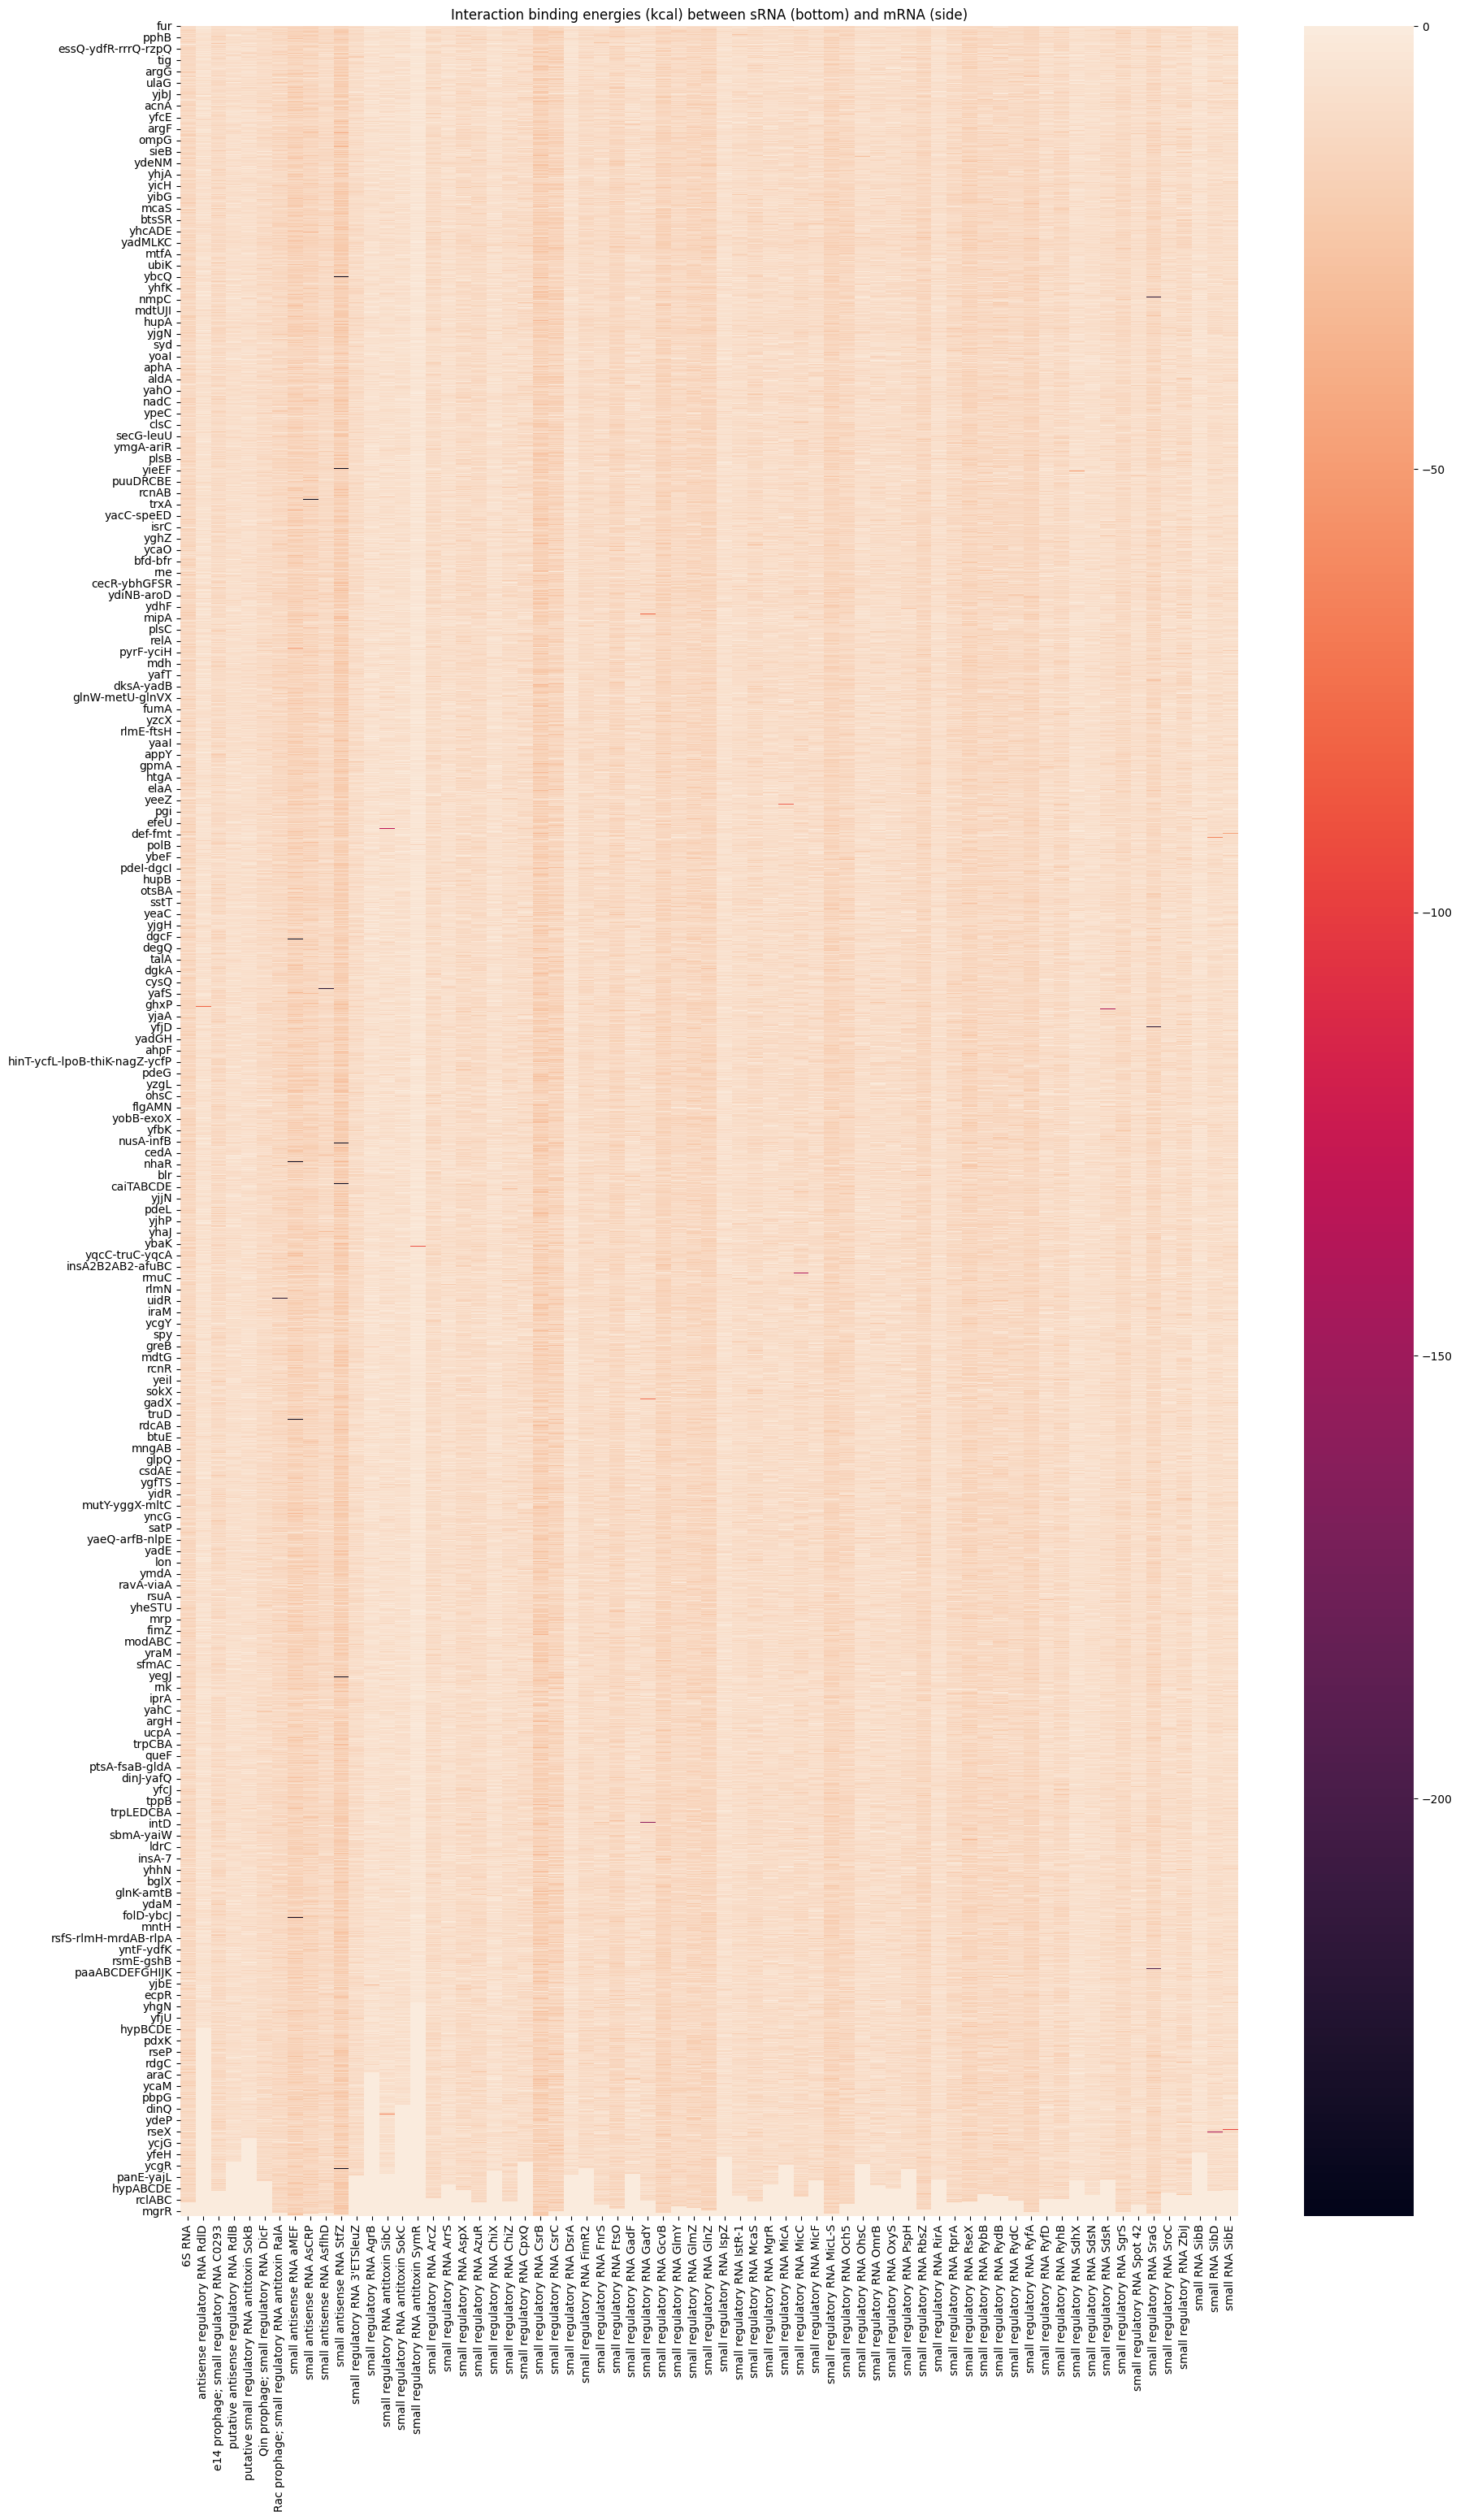

In [172]:
fig = plt.figure(figsize=(21, 35))

sns.heatmap(energies) # Spectral, cubehelix, vlag, icefire
plt.title('Interaction binding energies (kcal) between sRNA (bottom) and mRNA (side)')

### Binding site total length

Text(0.5, 1.0, 'Interaction binding side length (# nucleotides) between sRNA (bottom) and mRNA (side)')

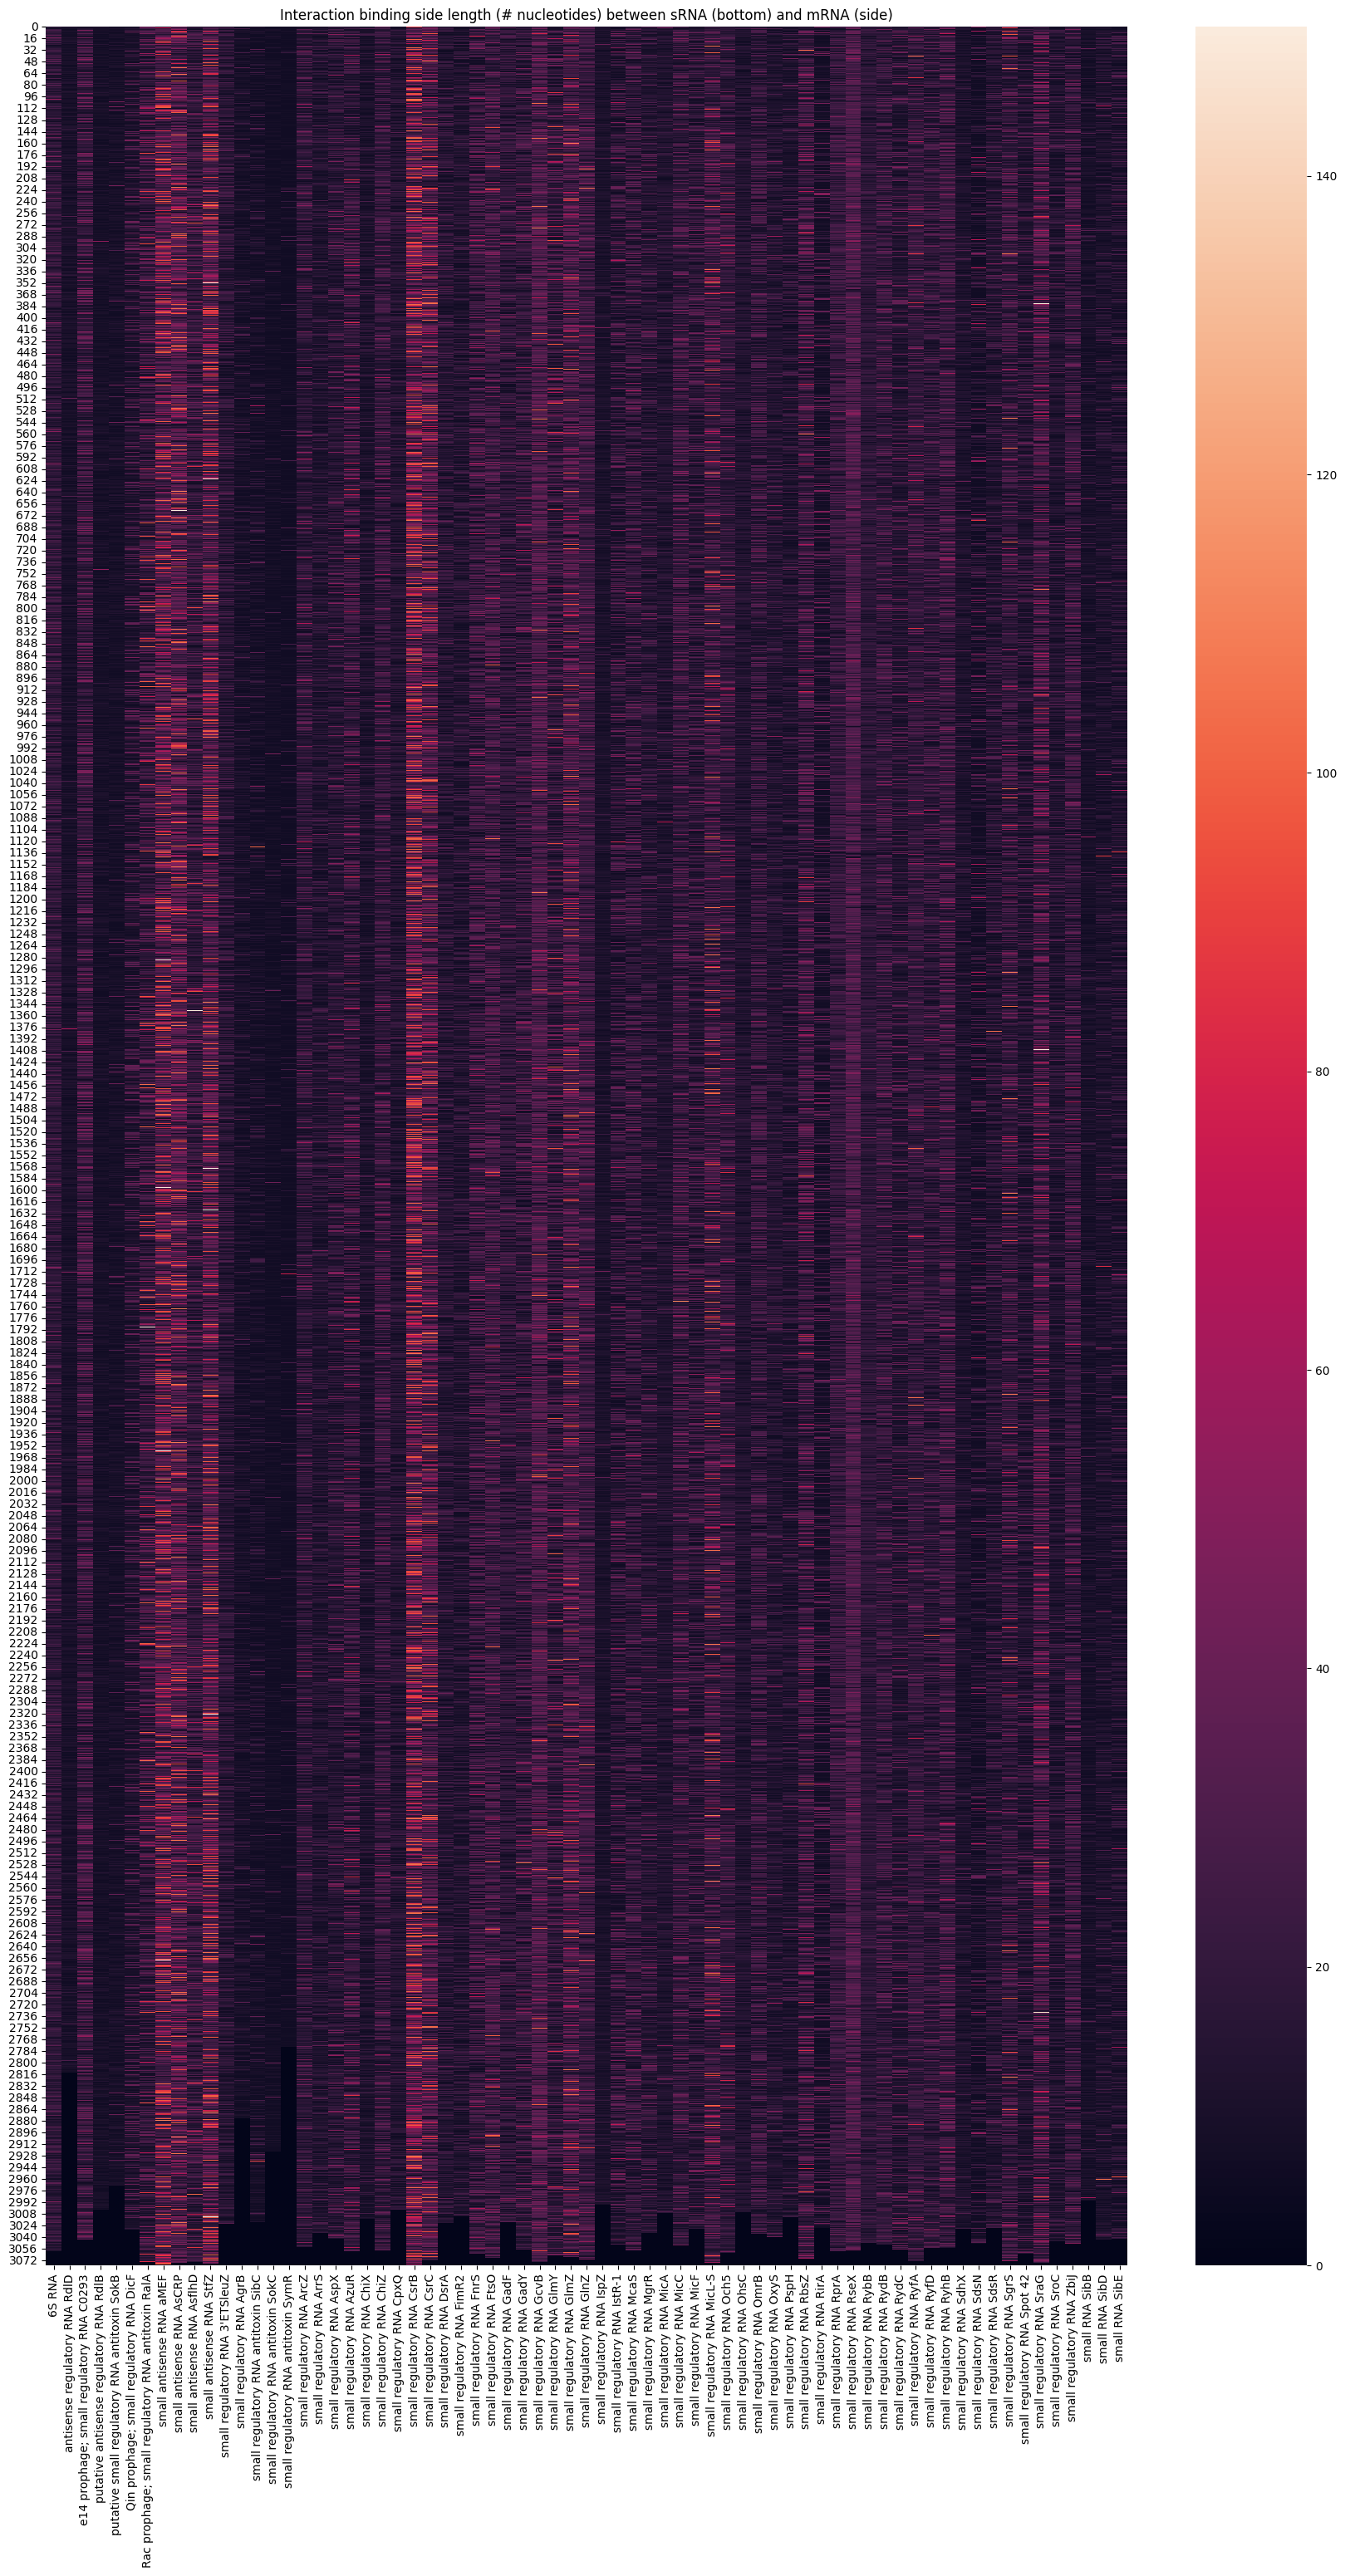

In [171]:
fig = plt.figure(figsize=(21, 35))

sns.heatmap(binding_site_total_length) # Spectral, cubehelix, vlag
plt.title('Interaction binding site length (# nucleotides) between sRNA (bottom) and mRNA (side)')

### Binding site groups

/tmp/ipykernel_112424/2922001065.py:2: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0.5)


Text(0.5, 1.0, 'Interaction number of binding site groups (# nucleotides) between sRNA (bottom) and mRNA (side)')

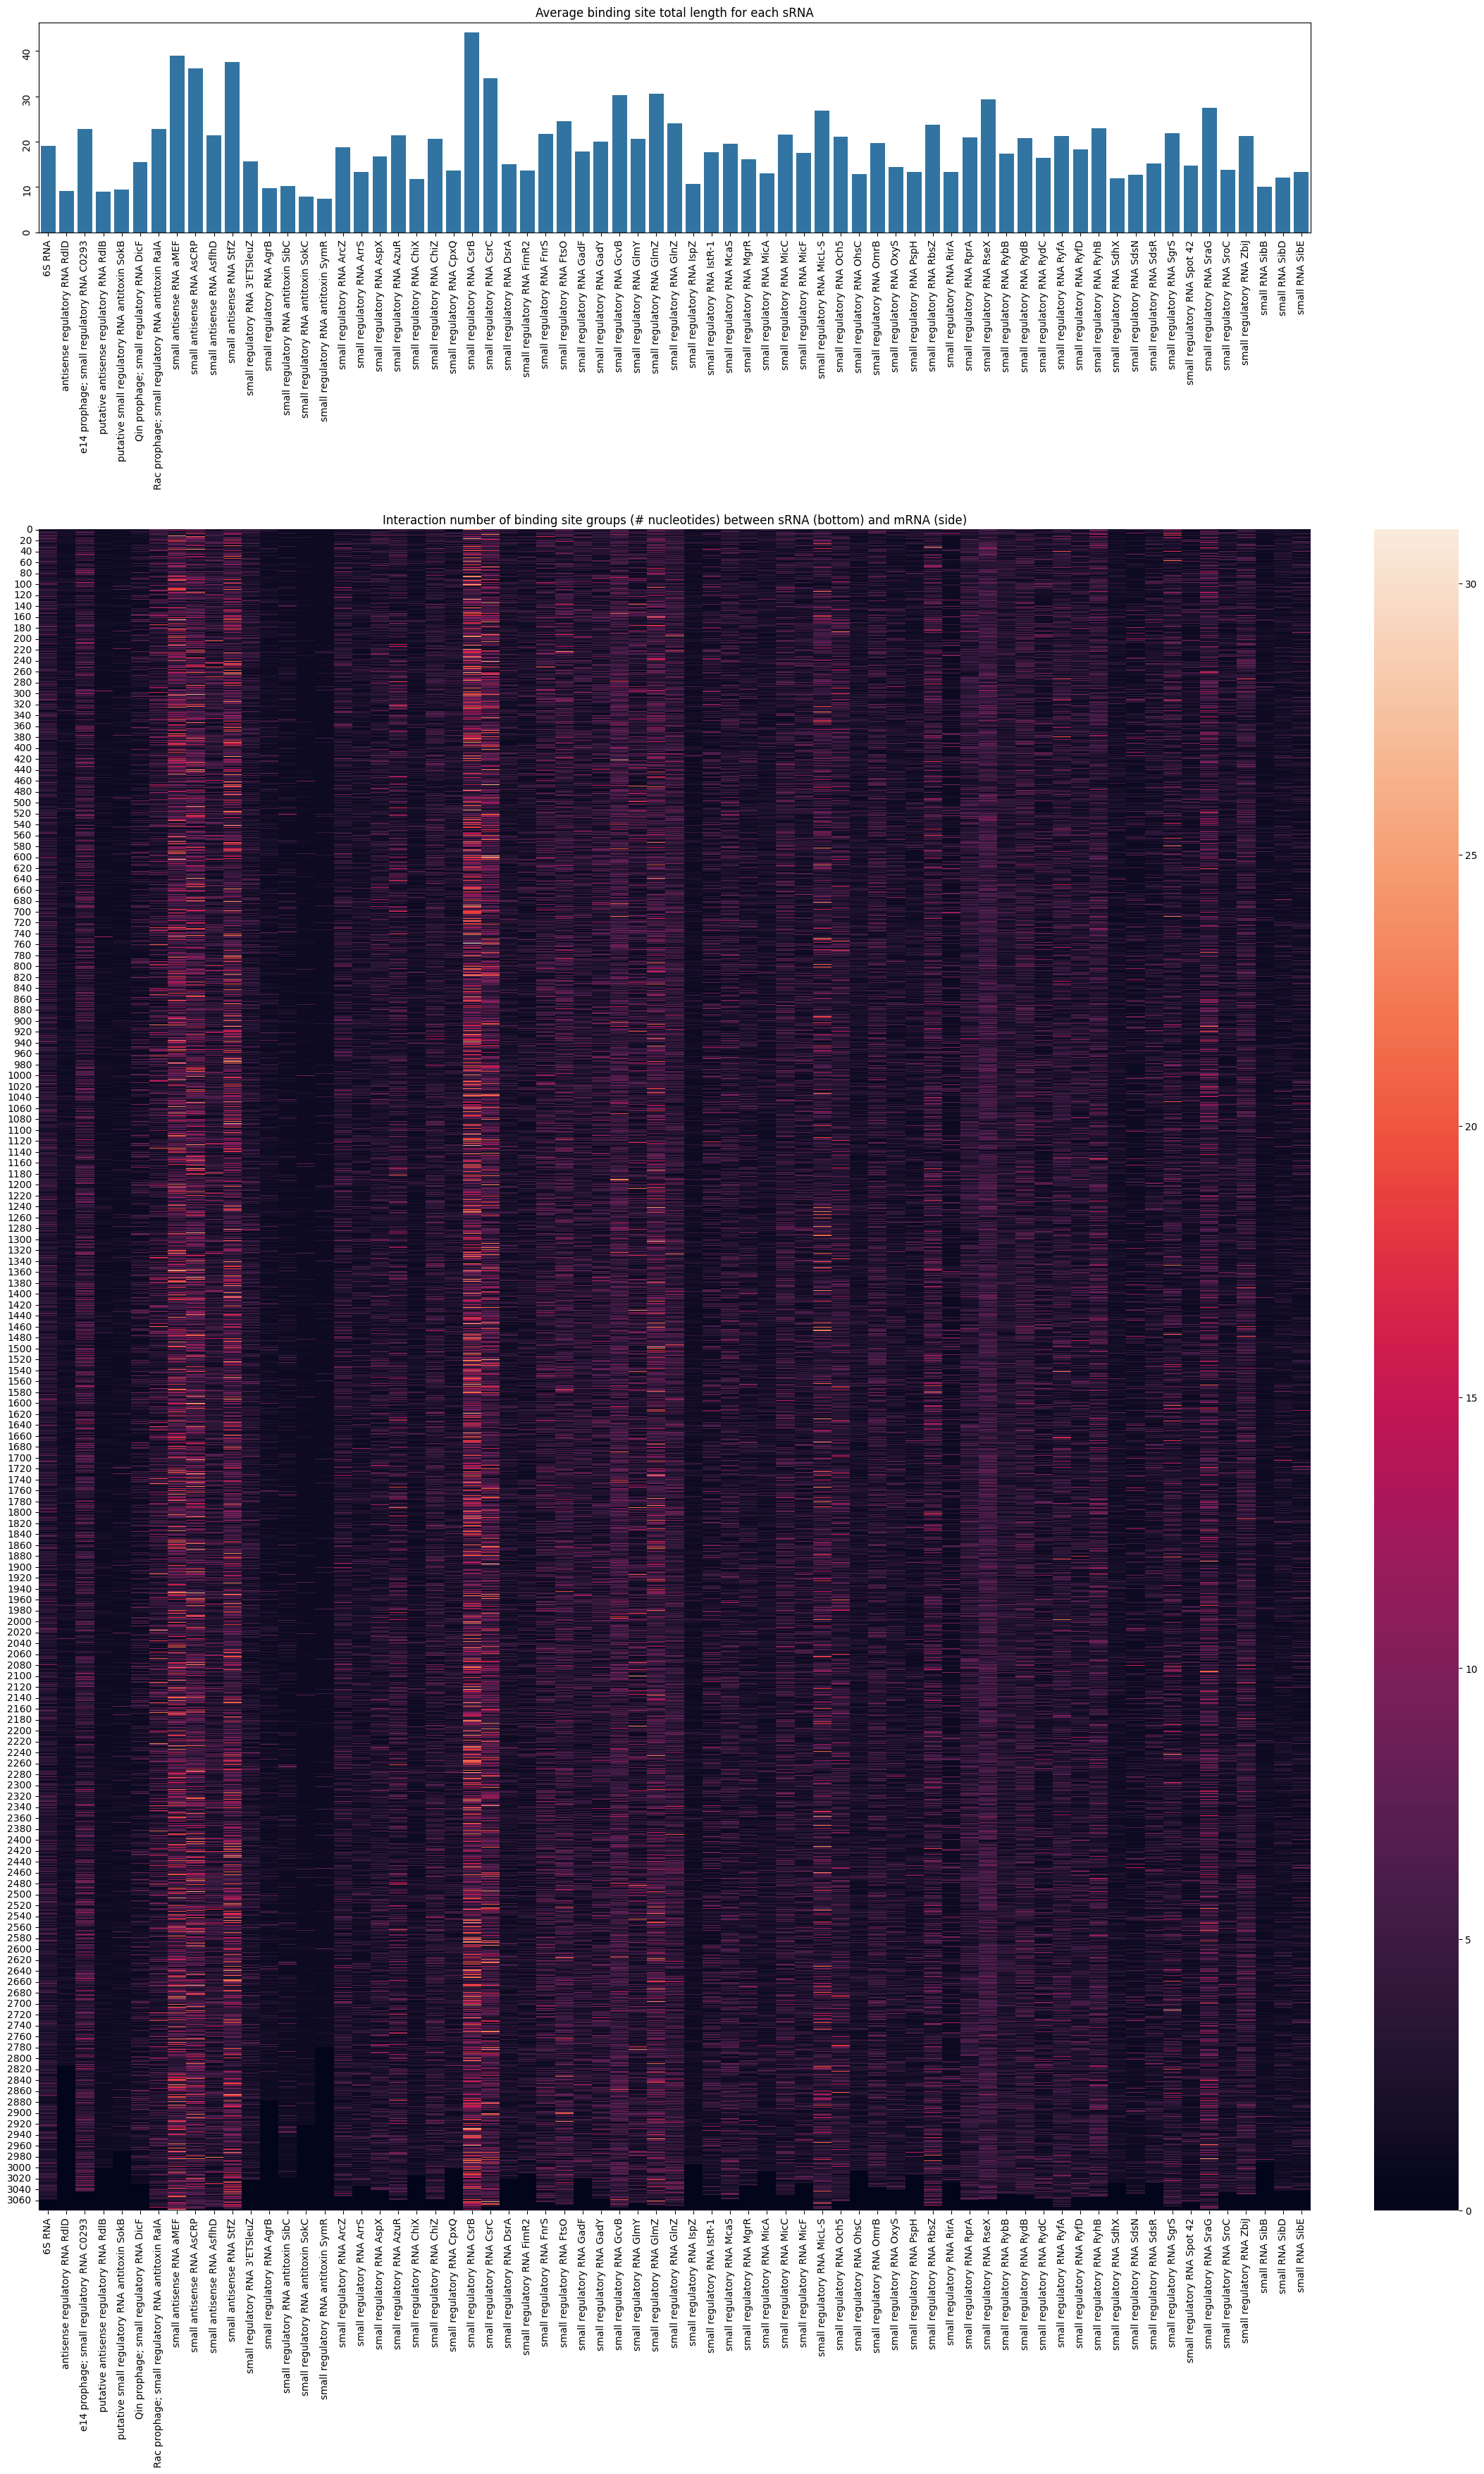

In [15]:
fig, axs = plt.subplots(2,1,figsize=(21, 35), gridspec_kw={'height_ratios': [1, 8]}, constrained_layout=True)
fig.subplots_adjust(hspace=0.5)

d_merged['Sequence length'] = d_merged['Sequence'].str.len()
sns.barplot(binding_site_total_length.mean(axis=0), ax=axs[0]) #, order=[l.label1._text for l in cax.ax_heatmap.get_xaxis().majorTicks])
axs[0].tick_params(rotation=90)
axs[0].set_title('Average binding site total length for each sRNA')

sns.heatmap(binding_site_groups, ax=axs[1]) # Spectral, cubehelix, vlag
axs[1].set_title('Interaction number of binding site groups (# nucleotides) between sRNA (bottom) and mRNA (side)')


## Visualise normalised clustermap

/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, 1.0, 'sRNA (bottom) interaction with all E. coli mRNA (side) binding energies (kcal)\nNormalised by total length of binding sites')

<Figure size 2100x2700 with 0 Axes>

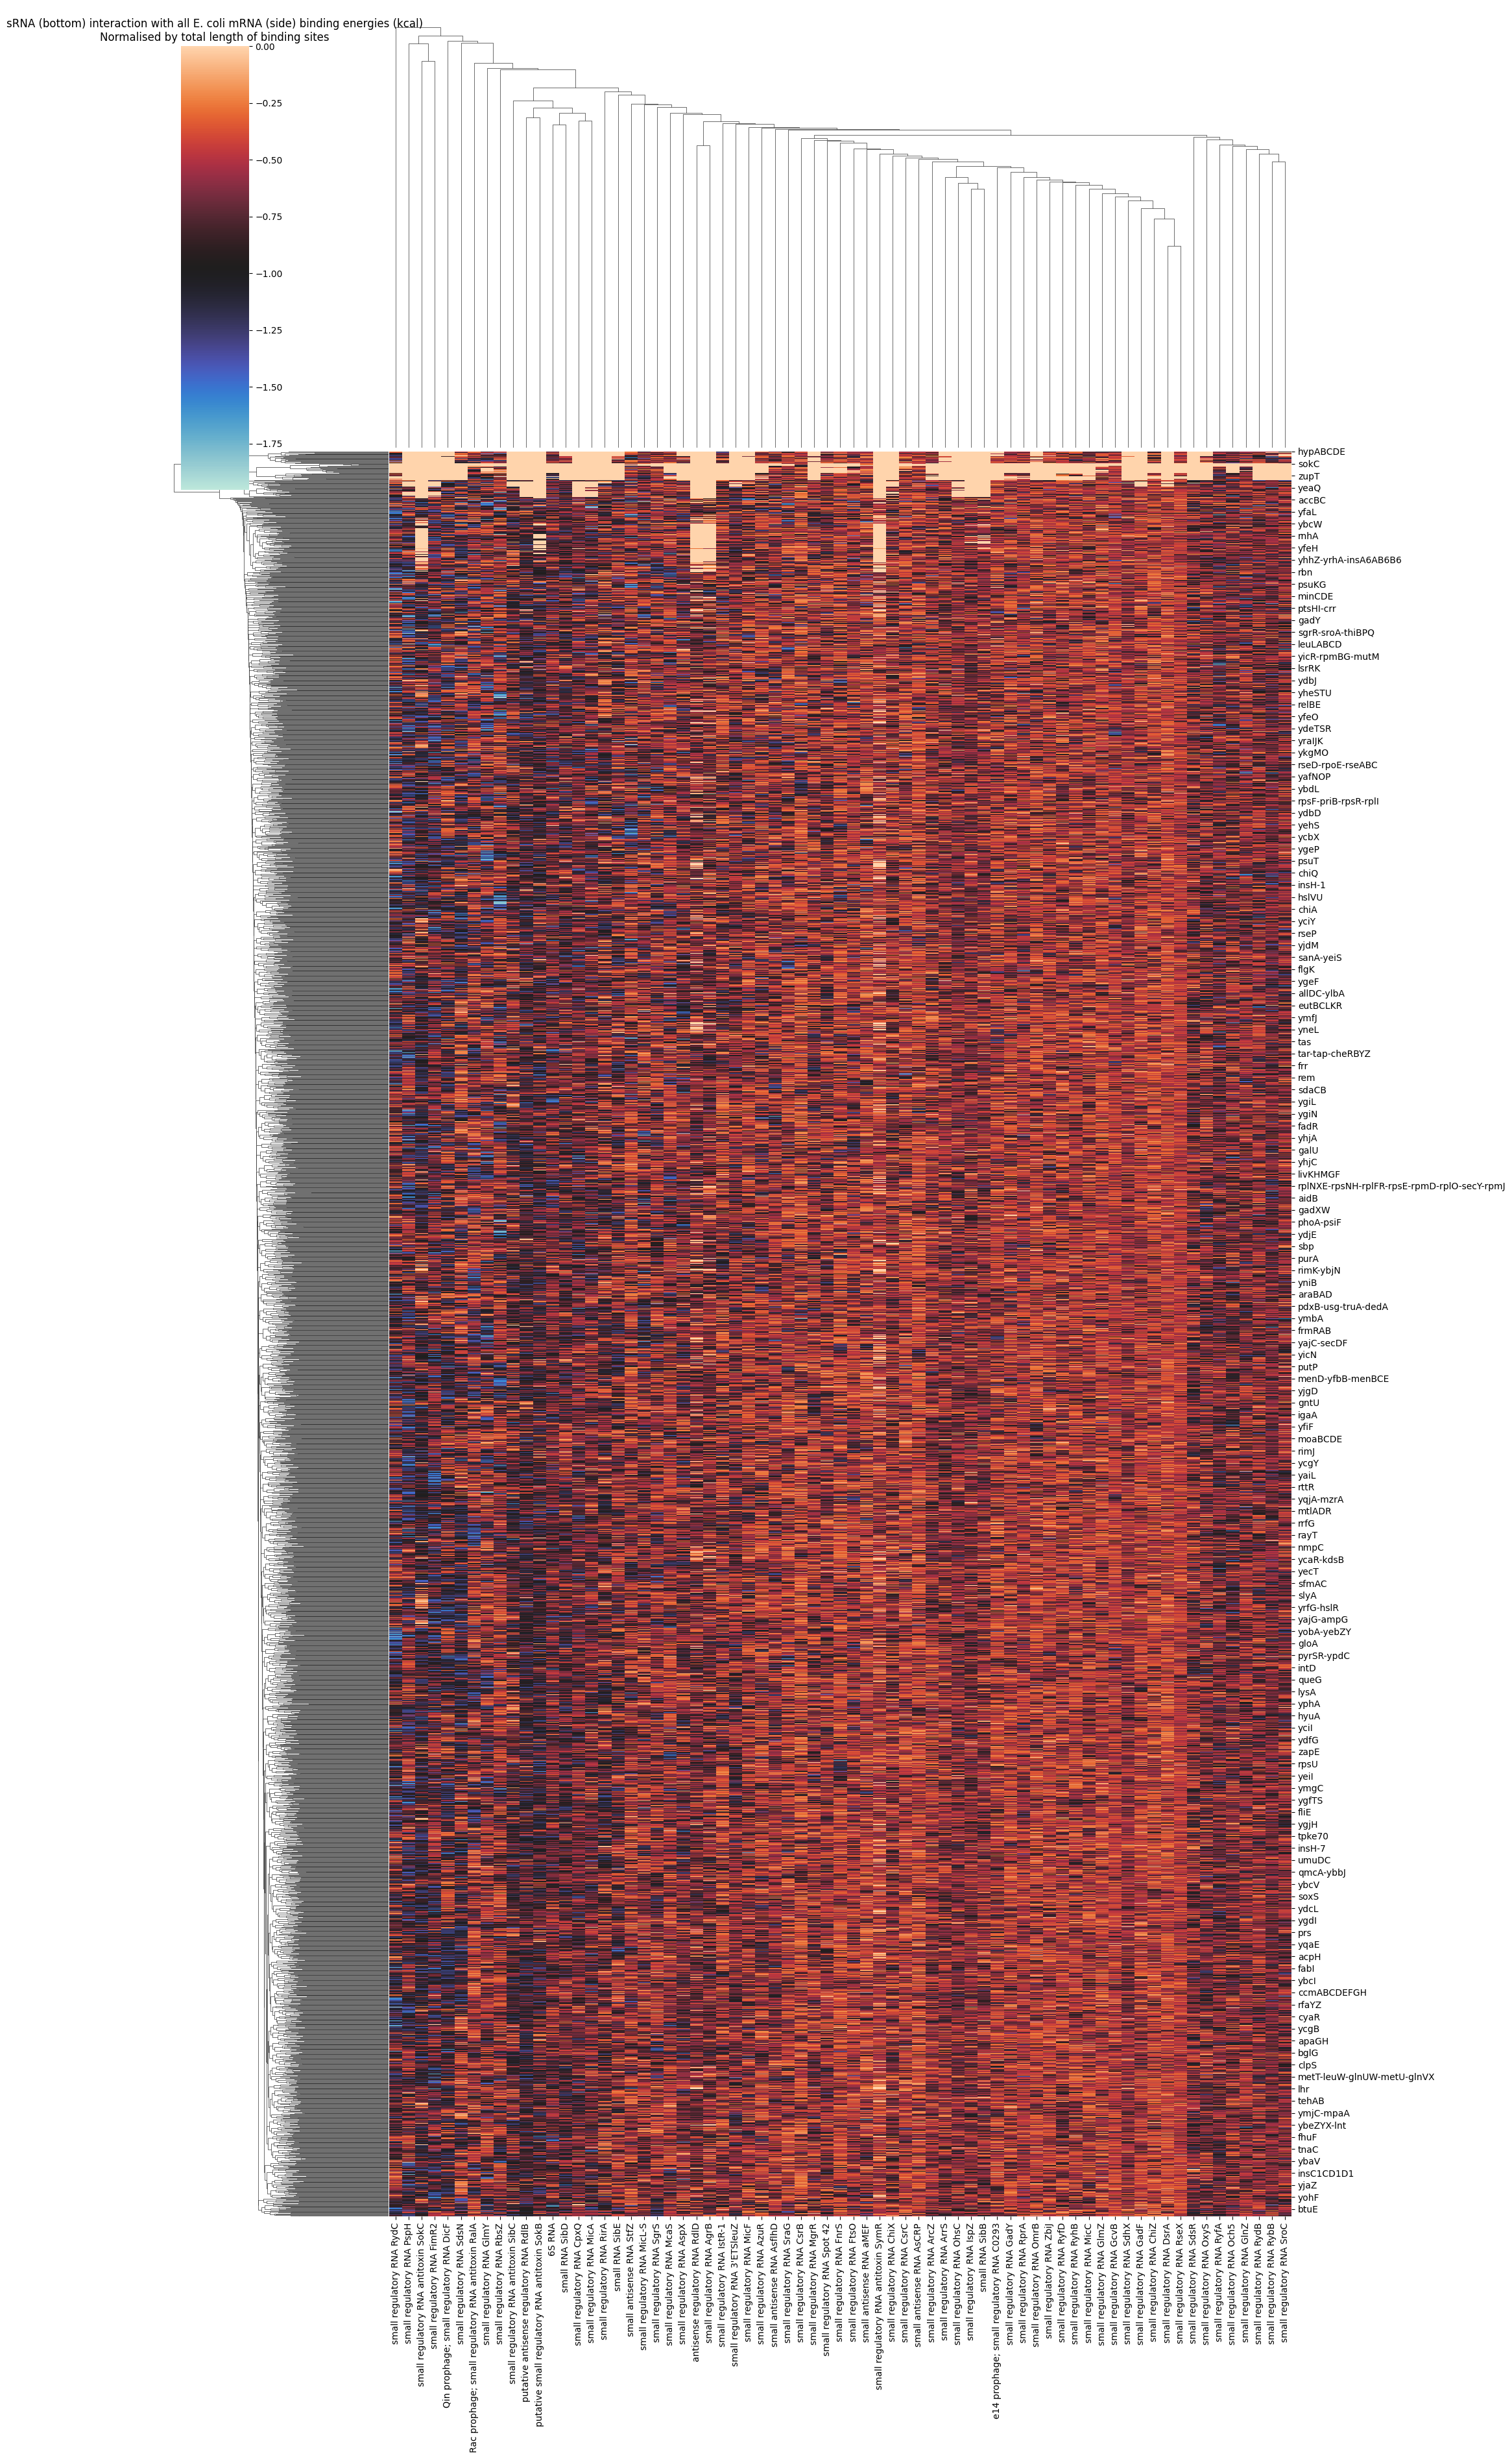

In [132]:
fig = plt.figure(figsize=(21, 27), constrained_layout=True)
cax = sns.clustermap(energies / np.where(binding_site_total_length == 0, 1, binding_site_total_length.to_numpy()), figsize=(21, 38), cmap= 'icefire') # Spectral, cubehelix, vlag
# sns.heatmap(energies / np.where(binding_site_total_length == 0, 1, binding_site_total_length.to_numpy()), cmap= 'icefire') # Spectral, cubehelix, vlag
plt.title('sRNA (bottom) interaction with all E. coli mRNA (side) binding energies (kcal)\nNormalised by total length of binding sites')

## Visualise heatmap

/tmp/ipykernel_93324/1810614249.py:2: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0.5)


Text(0.5, 1.0, 'sRNA (bottom) interaction with all E. coli mRNA (side) binding energies (kcal)\nNormalised by total length of binding sites')

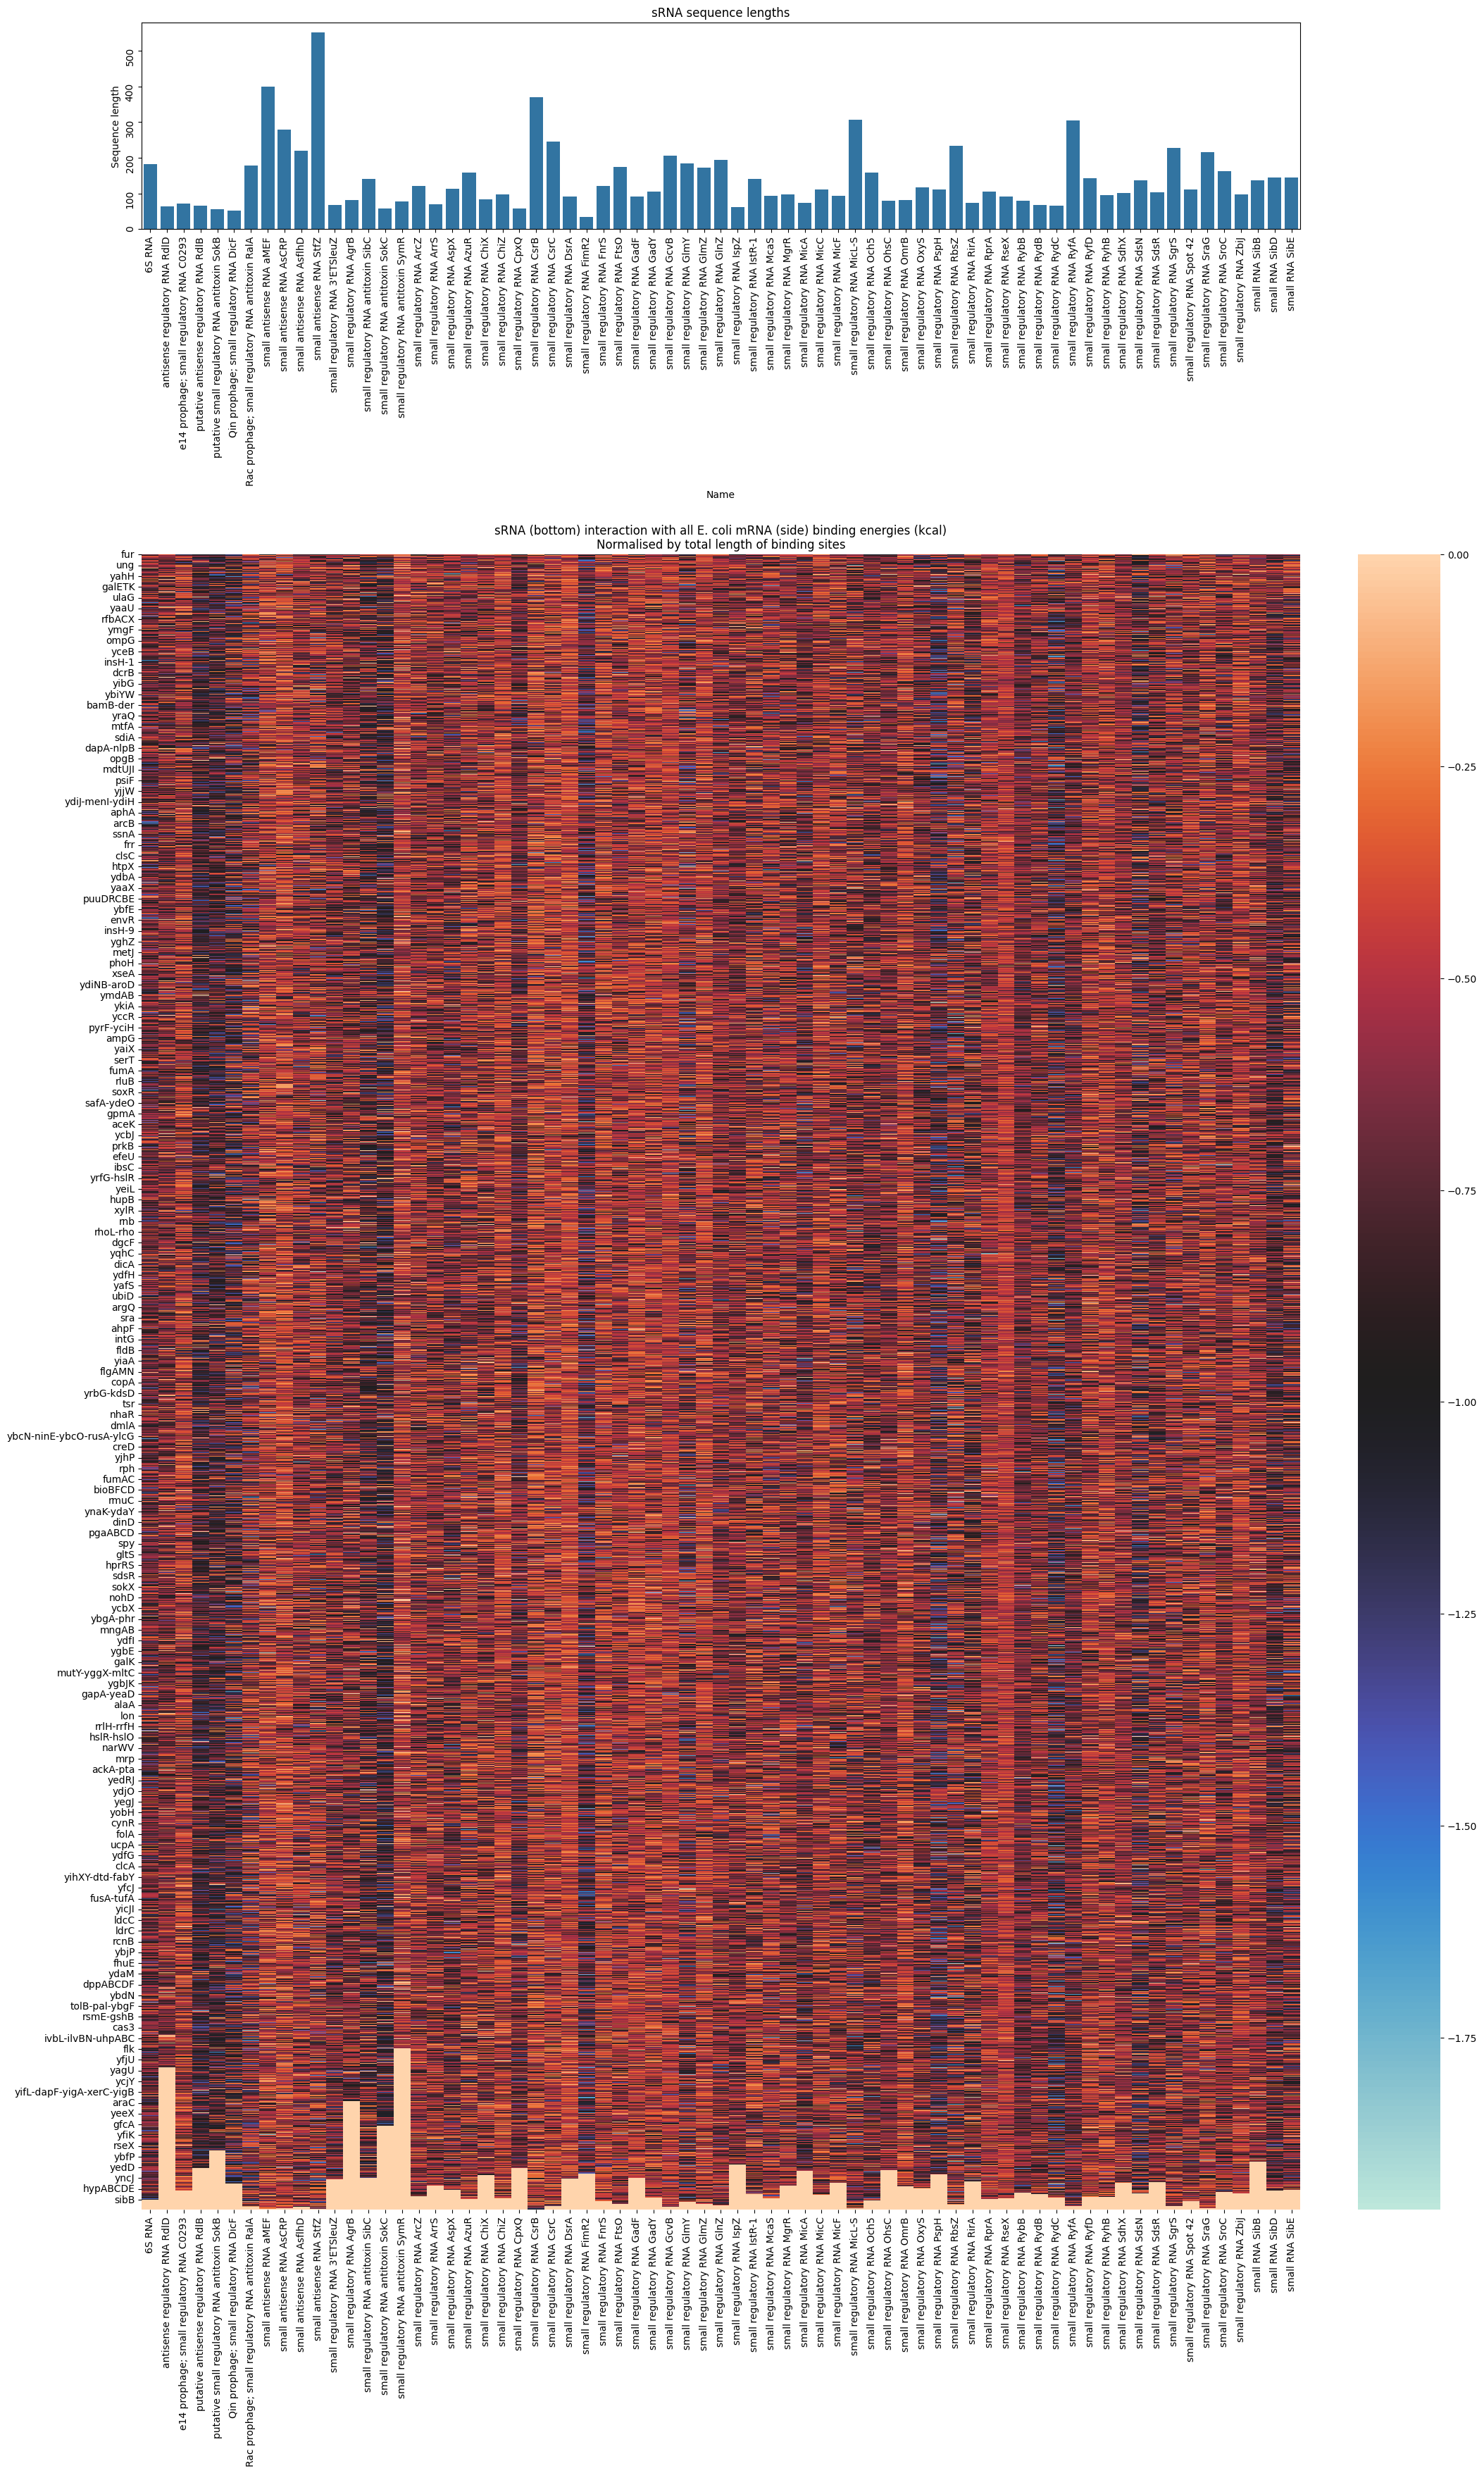

In [131]:
fig, axs = plt.subplots(2,1,figsize=(21, 35), gridspec_kw={'height_ratios': [1, 8]}, constrained_layout=True)
fig.subplots_adjust(hspace=0.5)

d_merged['Sequence length'] = d_merged['Sequence'].str.len()
sns.barplot(d_merged[d_merged['Category'] == 'sRNA'], y='Sequence length', x='Name', ax=axs[0]) #, order=[l.label1._text for l in cax.ax_heatmap.get_xaxis().majorTicks])
axs[0].tick_params(rotation=90)
axs[0].set_title('sRNA sequence lengths')

sns.heatmap(energies / np.where(binding_site_total_length == 0, 1, binding_site_total_length.to_numpy()), cmap= 'icefire', ax=axs[1]) # Spectral, cubehelix, vlag
axs[1].set_title('sRNA (bottom) interaction with all E. coli mRNA (side) binding energies (kcal)\nNormalised by total length of binding sites')

Verify that the non-interactions really are zeros. Run the printed sequences through IntaRNA

In [160]:
s = 'antisense regulatory RNA RdlD'
m = 'sra'
print('\nmRNA: ', m, '\t', mrnas[m])
print('sRNA: ', s, '\t', srnas[s])


mRNA:  sra 	 CAACCTAATTTAGGGGTTTAGCACGTGTTTCTTCGCTACGGCGATGTTGTCCTTAAAACTAGCTACAGGATTGAGGAGTTAAAATGAAATCGAACCGTCAGGCACGTCATATTCTTGGACTGGACCATAAAATTTCTAACCAGCGCAAAATAGTTACCGAAGGTGACAAATCCAGCGTAGTAAATAACCCAACCGGCAGAAAACGCCCCGCTGAAAAGTAA
sRNA:  antisense regulatory RNA RdlD 	 GTCTAGAGTCAAGATTAGCCCCCGTGGTGTTGTCAGGTGCATACCTGCAACGTGCGGGGGTTTT


In [165]:
sim_data_l = load_json_as_dict('data/07_orthogonality_mRNA_all/2023_11_12_112610/inter_data_raw.json')
for s, v in sim_data_l.items():
    if len(v.values()) < len(mrnas):
        diffs = set(mrnas.keys()) - set(v.keys())
        print(s, diffs)
        break

m = list(diffs)[0]
print('\nmRNA: ', m, '\t', mrnas[m])
print('sRNA: ', s, '\t', srnas[s])

6S RNA {'sibB', 'pheM', 'hisL', 'sibC', 'micA', 'yjjY', 'glyU', 'rdlD', 'istR-2', 'yabR', 'leuV', 'istR-1', 'mgrR', 'tpke11', 'sokC', 'ryfD', 'symR', 'fnrS', 'trpL'}

mRNA:  sibB 	 GAGGGTAGAGCGGGGTTTCCCCCGCCCTGGTAGTCTTAGTAAGCGGGGAAGCTTATGACTAAGAGCACCACGATGATGAGTAGCTTCATCATGACCCTTTCCTTATTTATGGCCCCTTCCTCGGGAGGGGCTTTCC
sRNA:  6S RNA 	 ATTTCTCTGAGATGTTCGCAAGCGGGCCAGTCCCCTGAGCCGATATTTCATACCACAAGAATGTGGCGCTCCGCGGTTGGTGAGCATGCTCGGTCCGTCCGAGAAGCCTTAAAACTGCGACGACACATTCACCTTGAACCAAGGGTTCAAGGGTTACAGCCTGCGGCGGCATCTCGGAGATTC


They do seem to be accurate non-interactions after running a couple of them on IntaRNA :)